# Цель работы
Изучить основные принципы многокритериальной оптимизации в комбинации с методами случайного и прямого пассивного поиска применительно к задаче фильтрации дискретного сигнала методом взвешенного скользящего среднего.

# Постановка задачи
На интервале $[x_{min}, x_{max}]$ задан сигнал $f_k=f(x_k)$, где дискретная последовательность  отсчетов задается как
\begin{align*}
&x_k = x_{min} + \frac{k(x_{max} - x_{min})}{K},\\
&k \in [0, K],\\
&K - \text{количество отсчетов}.
\end{align*}

На сигнал наложен дискретный равномерный шум $\sigma = (\sigma_0, ..., \sigma_K)$ с нулевым средним значением и амплитудой, равномерно распределенной на интервале
\begin{align*}
[-a, a]: \tilde{f_k} &= f_k + \sigma_k,\\
\sigma_k &= rnd(-a, a).
\end{align*}

В зависимости от варианта работы необходимо осуществить фильтрацию сигнала $\tilde{f_k}$ одним из **методов взвешенного скользящего среднего**.

В лабораторной работе используется модельная задача со следующими исходными данными:
\begin{align*}
&f_k = \sin(x_k) + 0.5,\\
&x_{min} = 0,\ x_{max} = \pi,\\
&K = 100
\end{align*}
- амплитуда равномерного шума $2а = 0.5$,
- дискретизация веса свертки $\lambda_l = l / L, l \in [0, L], L = 10$,
- вероятность попадания в окрестность экстремума $Р = 0.95$,
- интервал неопределенности $\epsilon = 0.01$,
- размер скользящего окна: $r = 3, r = 5$,
- метод фильтрации: среднее гармоническое,
- метрика близости: Чебышева.

# Практическая часть

## Подготовительная часть

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display, HTML
sns.set()

In [2]:
kTolerance = 1e-2
kWindowSizes = [3, 5]
kNoiseAmplitude = 0.25
kAcceptanceRate = 0.95
kSamplingDensity = 100
kConvolutionWeightDensity = 10

In [3]:
def f(x):
  return np.sin(x) + 0.5

def f_noisy(x):
  return f(x) + np.random.uniform(-kNoiseAmplitude, kNoiseAmplitude, len(x))

### 

In [4]:
x_min , x_max = 0, np.pi
step = (x_max - x_min) / kSamplingDensity
points = np.arange(x_min, x_max + step, step)

In [5]:
values = f(points)
values_noisy = f_noisy(points)
value_min = np.min(values) - 2 * kNoiseAmplitude
value_max = np.max(values) + 2 * kNoiseAmplitude

In [6]:
sample_size = int(np.log(1 - kAcceptanceRate) / np.log(1 - kTolerance / (x_max - x_min)))
print(f'Amount of points for random search optimization: {sample_size}')

Amount of points for random search optimization: 939


## Линейная свертка

### Среднее гармоническое
$$
\bar{f}_k(\alpha) = \left(\sum_{j = k - M}^{k + M} \frac{\alpha_{j + M + 1 - k}}{\tilde{f}_j} \right)^{-1},\\
k \in [M, K - M],
$$
величина $M$ выбирается из следующих соображений: $r = 2M + 1$ - размер заданного окна усреднения,
$\alpha = (\alpha_1, ..., \alpha_r)$ - нормированные весовые коэффициенты, такие что
$$
\sum_{j = 1}^{r} \alpha_j = 1,\\
\alpha_j \geq 0.
$$

Набор весов $\alpha$ должен обеспечивать оптимизацию отфильтрованного сигнала по критериям зашумленности $\omega$ и отличия $\delta$:
$$
\omega(\alpha) \rightarrow \min_{\alpha},\\
\delta(\alpha) \rightarrow \min_{\alpha}.
$$


In [7]:
def f_harmonic_mean(window_size, alpha, k):
  M = int((window_size - 1) / 2)

  sum = 0
  if k < M:
      for i in range(k + M + 1):
          sum += alpha[i] / values_noisy[i]
  elif k + M > kSamplingDensity - 1:
      for i in range(k - M, kSamplingDensity):
          sum += alpha[i - k + M] / values_noisy[i]
  else:
      for i in range(k - M, k + M + 1):
          sum += alpha[i - k + M] / values_noisy[i]
    
  return 1 / sum

### Критерий зашумленности $\omega$
$$
\omega: \max_{k \in [1, K]}{|\bar{f}_k - \bar{f}_{k - 1}|}
$$

In [8]:
def noisiness(window_size, alpha):
  return max([
    abs(f_harmonic_mean(window_size, alpha, i) - f_harmonic_mean(window_size, alpha, i - 1))
    for i in range(1, kSamplingDensity)
  ])

### Критерий отличия $\delta$
$$
\delta: \max_{k \in [0, K]}{|\bar{f}_k - \tilde{f}_{k}|}
$$

In [9]:
def distinction(window_size, alpha):
  return max([
    abs(f_harmonic_mean(window_size, alpha, i) - values_noisy[i])
    for i in range(kSamplingDensity)
  ])

### Линейная свертка
$$
J = \lambda\omega + (1 - \lambda)\delta \rightarrow \min_{\alpha},\\
\lambda \in [0, 1].
$$

In [10]:
def linear_convolution(window_size, alpha, lmbd):
  omega = noisiness(window_size, alpha)
  delta = distinction(window_size, alpha)
  return lmbd * omega + (1 - lmbd) * delta

In [11]:
def generate_alpha(window_size):
  M = int((window_size - 1) / 2)
  alpha = np.zeros(window_size)

  # central alpha coefficient
  alpha[M] = np.random.uniform(0, 1)

  for i in range(1, M):
    sum = np.sum(alpha[i + 1 : window_size - i - 1])
    alpha[i] = alpha[window_size - i - 1] = np.random.uniform(0, 1 - sum) / 2
  
  sum = np.sum(alpha[1 : window_size - 1])
  alpha[0] = alpha[window_size - 1] = (1 - sum) / 2

  return alpha

In [12]:
def generate_lambdas():
  step = 1 / kConvolutionWeightDensity
  return np.arange(start = 0, stop = 1 + step, step = step)

In [13]:
def get_optimal_alpha(window_size, lmbd):
  optimal_alpha = generate_alpha(window_size)
  optimal_value = linear_convolution(window_size, optimal_alpha, lmbd)
  
  for _ in range(sample_size - 1):
    alphas = generate_alpha(window_size)
    value = linear_convolution(window_size, alphas, lmbd)
    if value < optimal_value:
      optimal_value = value
      optimal_alpha = alphas
  return optimal_alpha

In [14]:
def chebyshev_distance(window_size, alpha):
  return max(distinction(window_size, alpha), noisiness(window_size, alpha))

## Фильтрация

In [15]:
def filter(window_size):
  omegas = []
  deltas = []
  distances = []
  optimal_alphas = []
  lambdas = generate_lambdas()

  for lmbd in lambdas:
    min_lc = np.inf
    optimal_alpha = get_optimal_alpha(window_size, lmbd)
    distance = chebyshev_distance(window_size, optimal_alpha)
    lc_value = linear_convolution(window_size, optimal_alpha, lmbd)
    if lc_value < min_lc:
      min_lc = lc_value

    omegas.append(noisiness(window_size, optimal_alpha).round(4))
    deltas.append(distinction(window_size, optimal_alpha).round(4))
    distances.append(distance.round(4))
    optimal_alphas.append(optimal_alpha.round(4))

  argmin = np.argmin(distances)
  optimal_lambda = lambdas[argmin]
  optimal_alpha = optimal_alphas[argmin]
  values_filtered = [
    f_harmonic_mean(window_size, optimal_alpha, k)
    for k in range(kSamplingDensity + 1)
  ]

  data = {'x': points, 'plain': values}
  data_noisy = {'x': points, 'noisy': values_noisy}
  data_filtered = {'x': points, 'filtered': values_filtered}

  plt.figure(figsize=[16, 9])
  plt.ylim([value_min, value_max])
  plt.plot('x', 'plain', 'o-', markersize=4, data=data)
  plt.plot('x', 'noisy', 'o-', markersize=4, data=data_noisy)
  plt.plot('x', 'filtered', 'o-', markersize=4, data=data_filtered)

  plt.xlabel('x')
  plt.ylabel('lc_value')

  plt.title(f'window size = {window_size}, optimal lambda = {optimal_lambda}')
  plt.legend()
  plt.show()

  df = pd.DataFrame(
    data=np.array([
      lambdas, omegas, deltas, distances, optimal_alphas], dtype=object
    ).transpose(),
    columns=['lambdas', 'omegas', 'deltas', 'distances', 'optimal alphas']
  )
  display(HTML(df.to_html()))
  print(f'optimal J = {min_lc:.4f}, optimal lambda = {lambdas[argmin]}')
  
  plt.plot(omegas, deltas, 'o')
  plt.xscale('symlog')
  plt.grid()
  plt.show()

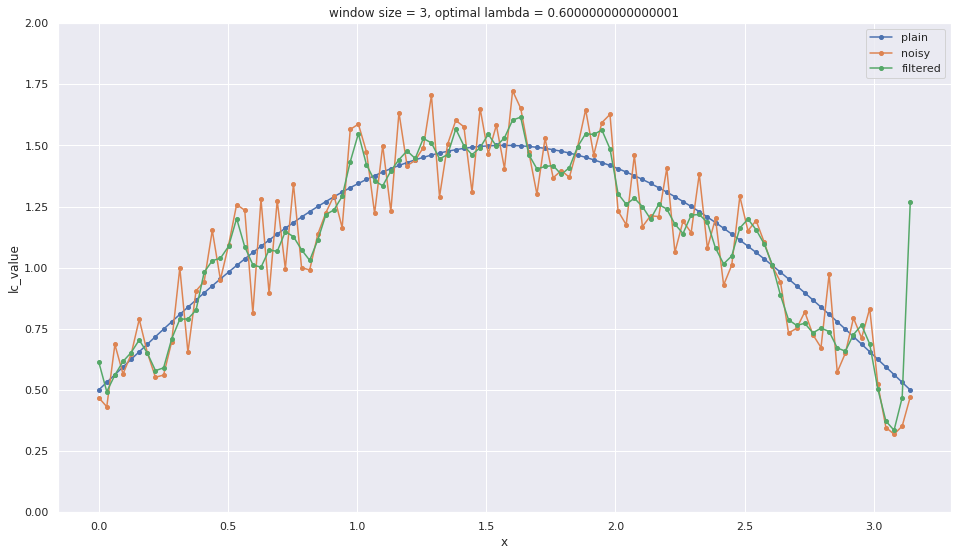

optimal J = 0.1702, optimal lambda = 0.6000000000000001


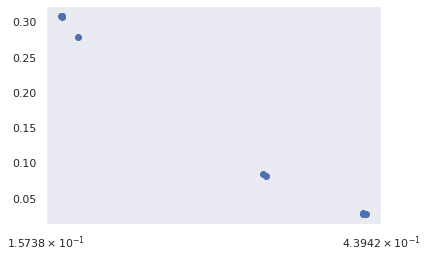

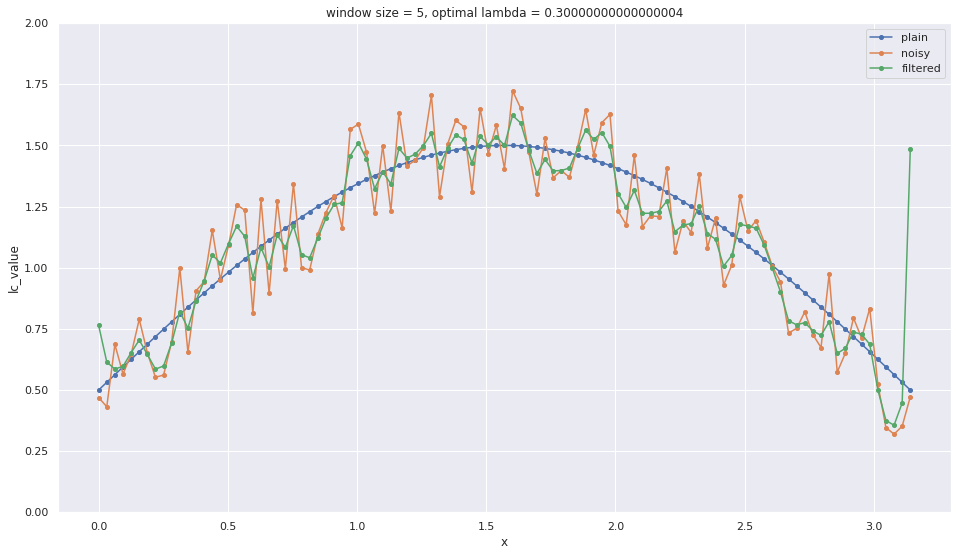

optimal J = 0.1515, optimal lambda = 0.30000000000000004


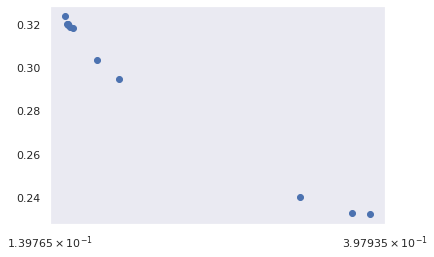

In [16]:
for window_size in kWindowSizes:
  filter(window_size)

# Выводы

В ходе этой лабораторной работы была осуществлена реализация алгоритма двухкритериальной оптимизации с использованием методов прямого пассивного поиска; была осуществлена фильтрация сигнала одним из методов взвешенного скользящего среднего (среднее гармоническое + метрика Чебышева).

В результате фильтрации был шум удалось незначительно сгладить.